In [67]:
import numpy as np
from scipy.optimize import minimize
from mygp import gp, kernel
import corner
import emcee

# setup plotting
import matplotlib.pyplot as pl
%matplotlib inline
import seaborn as sns
palette = sns.color_palette()
sns.set()

In [82]:
# takes readable params and makes a long list out of them
def make_params(n_samples, log_A=None, log_l=None, log_wn=None, c=None, mean_params=None, offset=None):
    if n_samples > 1:
        return np.concatenate(([log_A], [log_l], log_wn, [1], c, mean_params, offset))
    elif n_samples == 1:
        return np.concatenate(([log_A], [log_l], [log_wn], mean_params, [offset]))

# does the opposite
def unpack_params(params, n_samples, n_mean_params):
    
    if n_samples > 1:
        lengths = 1, 1, n_samples, n_samples, n_mean_params, n_samples
    elif n_samples == 1:
        lengths = 1, 1, 1, n_mean_params, 1
        
    breaks = [sum(lengths[:i]) for i in range(len(lengths))]
    breaks = np.concatenate((breaks, [len(params)]))
    return [params[breaks[i]:breaks[i+1]] for i in range(len(breaks)-1)]
        

# sample a GP with the given parameters, mean, and number of samples (at points t)
def make_data(params, mean_func, n_samples, n_mean_params, t):
    
    if n_samples > 1:
        log_A, log_l, log_wn, c, mean_params, offset = unpack_params(params, n_samples, n_mean_params)    
        k2 = kernel.scale_kernel([scale for scale in c])
    else:
        log_A, log_l, log_wn, mean_params, offset = unpack_params(params, n_samples, n_mean_params)
        k2 = None

    def make_mean(off): return (lambda x: mean_func(x, off, *mean_params))
    mean = [make_mean(off) for off in offset]
    
    k1 = kernel.exp_sq_kernel(np.exp(log_l), np.exp(log_A))
    
    dim = (n_samples > 1) + 1
    g = gp(mean, k1, kernel2=k2, wn=[np.exp(lwn) for lwn in log_wn], dim=dim)
    g.compute(t)
    data = g.sample()
    return data 

# returns the negative log likelihood for the GP with given parameters, mean, etc. as above
def neg_log_like(params, mean_func, n_samples, n_mean_params, t, data):
    
    if n_samples > 1:
        log_A, log_l, log_wn, c, mean_params, offset = unpack_params(params, n_samples, n_mean_params)  
        def make_mean(off): return (lambda x: mean_func(x, off, *mean_params))
        k2 = kernel.scale_kernel([scale for scale in c])
        mean = [make_mean(off) for off in offset]
    else:
        log_A, log_l, log_wn, mean_params, offset = unpack_params(params, n_samples, n_mean_params)    
        def make_mean(off): return (lambda x: mean_func(x, off, *mean_params))
        k2 = None
        mean = make_mean(offset)
   
    k1 = kernel.exp_sq_kernel(np.exp(log_l), np.exp(log_A))
    
    dim = (n_samples > 1) + 1
    g = gp(mean, k1, kernel2=k2, wn=[np.exp(lwn) for lwn in log_wn], dim=dim)
    g.compute(t)
    nll = -g.log_likelihood(data, x=t)
    return nll

# print the parameters nicely 
def print_params(params, n_samples, n_mean_params):
    if n_samples > 1:
        log_A, log_l, log_wn, c, mean_params, offset = unpack_params(params, n_samples, n_mean_params)
    elif n_samples == 1:
        log_A, log_l, log_wn, mean_params, offset = unpack_params(params, n_samples, n_mean_params)
    print('A: ', np.exp(log_A))
    print('l: ', np.exp(log_l))
    print('white noise: ', np.exp(log_wn))
    if n_samples > 1:
        print('scale factors: ', c)
    print('mean parameters: ', mean_params)
    print('offsets: ', offset)

# minimizes the negative log likelihood using L-BFGS-B
def fit_n_samples(p0, n_samples, n_mean_params, data, t, bounds=None):
    func = lambda p: neg_log_like(p, gauss, n_samples, n_mean_params, t, data)
    
    min_params = minimize(func, x0=p0, bounds=bounds, method='L-BFGS-B')
    return min_params.x

# does mcmc
def do_mcmc(p0, n_samples, n_steps, n_walkers, n_burnin, data, t):
    log_like = lambda p0, mean_func, n_samples, t, data: -neg_log_like(p0, mean_func, 
                                                                       n_samples, t, data)

    ndim, nwalkers = len(p0), n_walkers
    p0 = [p0 + 1e-4*np.random.randn(len(p0)) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like, 
                                    args=[gauss, n_samples, t, data])
    sampler.run_mcmc(p0, n_steps)
    samples = sampler.chain[:, n_burnin:, :].reshape((-1, ndim))
    return samples

In [74]:
# parameters for true mean and gp

true_log_A = np.log(100)
true_log_l = np.log(0.5)
true_log_wn = np.log([10, 5, 1])
true_c = [5, 10]
true_mean_params = [500, 5, 1]
true_offset = [0, 100, 200]

true_params = make_params(3, log_A=true_log_A, log_l=true_log_l, log_wn=true_log_wn, c=true_c, mean_params=true_mean_params, offset=true_offset)
t_single = np.linspace(0, 10, 300)
t = t_single[::3]
tp = np.linspace(0, 10, 1000)

def gauss(t, offset, A, t0, sig):
    return offset + A*np.exp(-((t - t0)**2)/(2*sig*sig))

In [75]:
# make the fake data

data = make_data(true_params, gauss, 3, 3, t_single)
data_single = data[0]
y1, y2, y3 = [d[::3] for d in data]

/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:35: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims)


True Parameters
---------------
A:  [100.]
l:  [0.5]
white noise:  [10.  5.  1.]
scale factors:  [ 1.  5. 10.]
mean parameters:  [500.   5.   1.]
offsets:  [  0. 100. 200.]


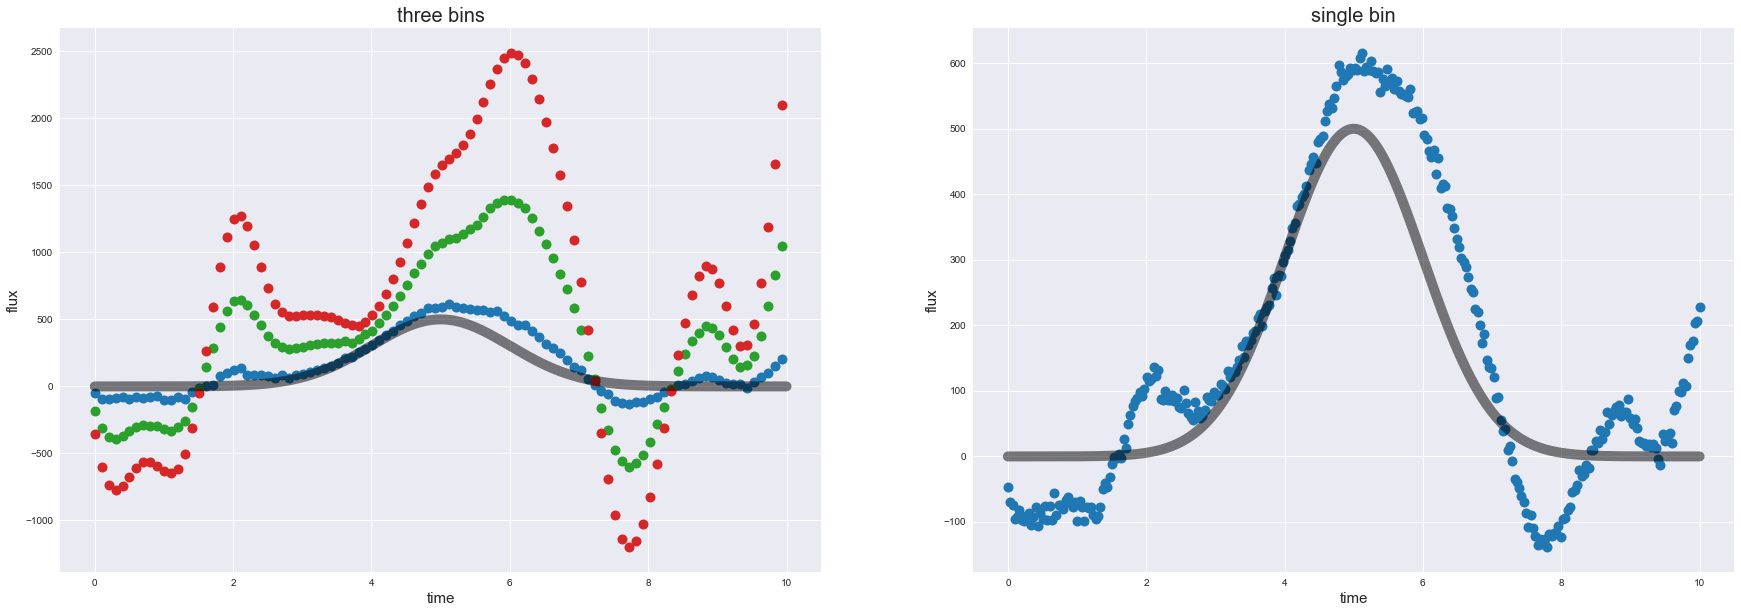

In [76]:
# plot the fake data and underlying mean 

fig, axs = pl.subplots(1, 2, figsize=(30, 10))

axs[0].plot(t, y1, 'o', alpha=1, color=palette[0], markersize=10)
axs[0].plot(t, y2, 'o', alpha=1, color=palette[2], markersize=10)
axs[0].plot(t, y3, 'o', alpha=1, color=palette[3], markersize=10)
axs[0].plot(tp, gauss(tp, true_offset[0], *true_mean_params), linewidth=10, color='k', alpha=0.5)

axs[1].plot(t_single, data_single, 'o', alpha=1, color=palette[0], markersize=10)
axs[1].plot(tp, gauss(tp, true_offset[0], *true_mean_params), linewidth=10, color='k', alpha=0.5)

axs[0].set_title('three bins', size=20)
axs[0].set_xlabel('time', size=15)
axs[0].set_ylabel('flux', size=15)

axs[1].set_title('single bin', size=20)
axs[1].set_xlabel('time', size=15)
axs[1].set_ylabel('flux', size=15)

#axs[0].set_ylim(-100, 100)
#axs[1].set_ylim(-100, 100)

print('True Parameters')
print('---------------')
print_params(true_params, 3, 3)

In [83]:
# minimize the single and triple-wavelength cases and plot the fits. 

# three wavelength case

# starting guesses for minimization
log_A = np.log(12)
log_l = np.log(1)
log_wn = np.log([5, 5, 5])
c = [2, 8]
mean_params = [100, 6, 2]
offset = [0, 80, 210]
p0 = make_params(3, log_A=log_A, log_l=log_l, log_wn=log_wn, c=c, mean_params=mean_params, offset=offset)

# L-BFGS-B minimization
min_params_multi = fit_n_samples(p0, 3, 3, [y1, y2, y3], t)

# single wavelength case
log_A = np.log(12)
log_l = np.log(1)
log_wn = np.log(5)
mean_params = [0, 6, 2]
offset = 0
p0 = make_params(1, log_A=log_A, log_l=log_l, log_wn=log_wn, mean_params=mean_params, offset=offset)
# L-BFGS-B minimization 
min_params_single = fit_n_samples(p0, 1, 3, data_single, t_single)

# print the best fit parameters for both cases
print('Best Fit Parameters - Multiple Bins')
print('---------------')
print(print_params(min_params_multi, 3, 3))
print(' ')
print('Best Fit Parameters - Single Bin')
print('---------------')
print_params(min_params_single, 1, 3)

/Users/tgordon/research/gp2d/mygp.py:194: RuntimeWarning: overflow encountered in double_scalars
  self.detK = np.prod(np.diag(self.L))**2
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:35: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims)


Best Fit Parameters - Multiple Bins
---------------
A:  [104.88750627]
l:  [0.50308419]
white noise:  [100.76614239  52.46001446   0.91895956]
scale factors:  [1.84547253 5.22991527 9.72873024]
mean parameters:  [121.83072029   4.76017962   1.08063569]
offsets:  [  9.43411413 122.37819064 172.77535612]
None
 
Best Fit Parameters - Single Bin
---------------
A:  [184.91533313]
l:  [0.62416028]
white noise:  [10.28388851]
mean parameters:  [1.32460342 6.00187539 2.1535956 ]
offsets:  [164.01666493]


Text(0,0.5,'flux')

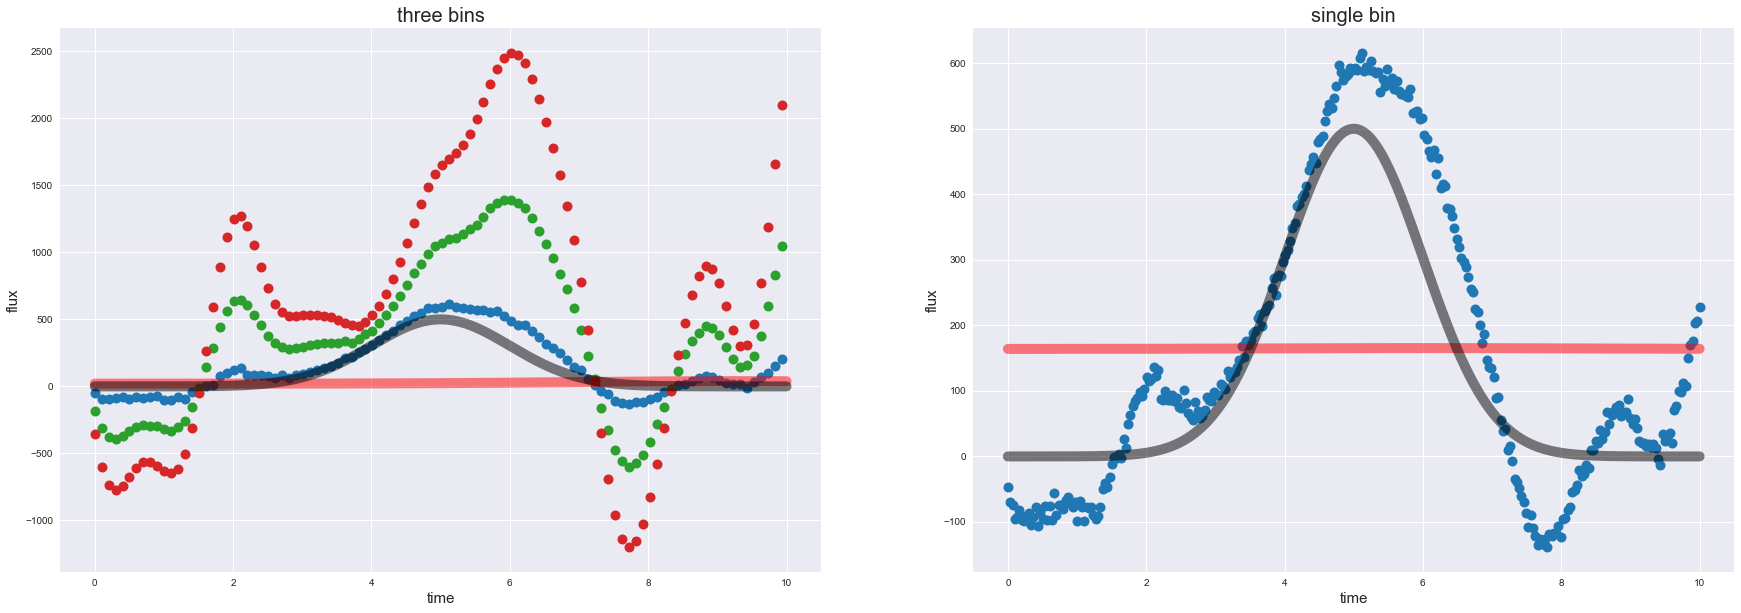

In [78]:
# plot fits
_, _, _, _, mean_params_multi, offset_multi = unpack_params(min_params_multi, 3, 3)
_, _, _, mean_params_single, offset_single = unpack_params(min_params_single, 1, 3)

fig, axs = pl.subplots(1, 2, figsize=(30, 10))
axs[0].plot(t, y1, 'o', alpha=1, color=palette[0], markersize=10)
axs[0].plot(t, y2, 'o', alpha=1, color=palette[2], markersize=10)
axs[0].plot(t, y3, 'o', alpha=1, color=palette[3], markersize=10)
axs[0].plot(tp, gauss(tp, offset_multi[0], *mean_params_multi), linewidth=10, color='r', alpha=0.5)
axs[0].plot(tp, gauss(tp, true_offset[0], *true_mean_params), linewidth=10, color='k', alpha=0.5)

axs[1].plot(t_single, data_single, 'o', alpha=1, color=palette[0], markersize=10)
axs[1].plot(tp, gauss(tp, offset_single[0], *mean_params_single), linewidth=10, color='r', alpha=0.5)
axs[1].plot(tp, gauss(tp, true_offset[0], *true_mean_params), linewidth=10, color='k', alpha=0.5)

axs[0].set_title('three bins', size=20)
axs[0].set_xlabel('time', size=15)
axs[0].set_ylabel('flux', size=15)

axs[1].set_title('single bin', size=20)
axs[1].set_xlabel('time', size=15)
axs[1].set_ylabel('flux', size=15)

#axs[0].set_ylim(-100, 100)
#axs[1].set_ylim(-100, 100)

In [ ]:
# do mcmc starting from best fit parameters for the three wavelength case
# this probably isn't ready yet. 

p0 = min_params_multi
samples = do_mcmc(p0, 3, 100, 100, 50, [y1, y2, y3], t)
fig = corner.corner(samples, labels=['l', 'wn1', 'wn2', 'wn3', 'c1', 'c2', 'A', 't0', 'sig'])

In [ ]:
# plot some samples from the mcmc chain over the true mean and data

fig = pl.figure(figsize=(12, 8))

for s in samples[np.random.randint(len(samples), size=50)]:
    pl.plot(tp, gauss(tp, s[-3], s[-2], s[-1]), color='k', alpha=0.1)
    
pl.plot(tp, gauss(tp, A, t0, sig), linewidth=10, color='r', alpha=0.5, label='true mean')
pl.plot(0, 0, color='k', label='mcmc results')
pl.plot(t, y1, 'o', alpha=1, color=palette[0], markersize=10, label='y1')
pl.plot(t, y2, 'o', alpha=1, color=palette[1], markersize=10, label='y2')
pl.plot(t, y3, 'o', alpha=1, color=palette[2], markersize=10, label='y3')
pl.title('single wavelength mcmc results')
pl.xlabel('t')
pl.ylabel('y')
pl.legend()

In [ ]:
# run mcmc on the single wavelength case

p0 = min_params_single
log_like = lambda p0, mean_func, n_samples, t, data: -neg_log_like(p0, mean_func, n_samples, t, data)
samples = do_mcmc(p0, 1, 100, 100, 50, data_single, t_single)
fig = corner.corner(samples, labels=['l', 'wn', 'A', 't0', 'sig'])

In [ ]:
# plot some mcmc samples from the single wavelength case over the data and true mean

fig = pl.figure(figsize=(12, 8))
for s in samples[np.random.randint(len(samples), size=1000)]:
    pl.plot(tp, gauss(tp, s[-3], s[-2], s[-1]), color='k', alpha=0.05)
    
pl.plot(0, 0, color='k', label='mcmc results')
pl.plot(tp, gauss(tp, A, t0, sig), linewidth=10, color='r', alpha=0.5, label='true mean')
pl.plot(t_single, data_single, 'o', alpha=1, color=palette[0], markersize=10, label='data')
pl.title('single wavelength mcmc results')
pl.xlabel('t')
pl.ylabel('y')
pl.legend()